# Contextual Bandit Based on Upper Confidence Bound for E-commerce Platform

This is a contextual bandit algorithm designed for an e-commerce platform with four contexts or channels. There are five models that run in each context. Model selection is based on the Upper Confidence Bound (UCB) algorithm.

Author: Okwudili Ezeme
Date: 2021-10-15


Average reward: 0.46469


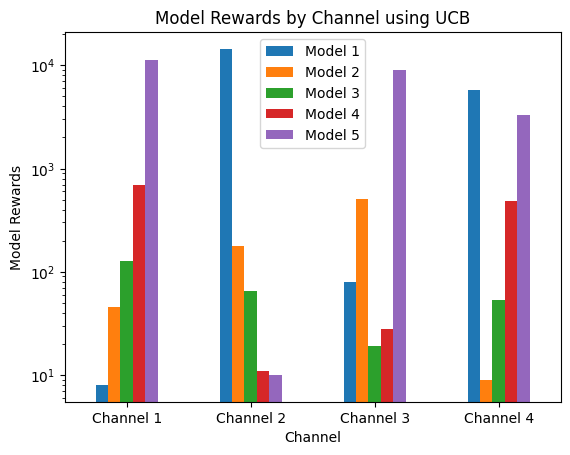

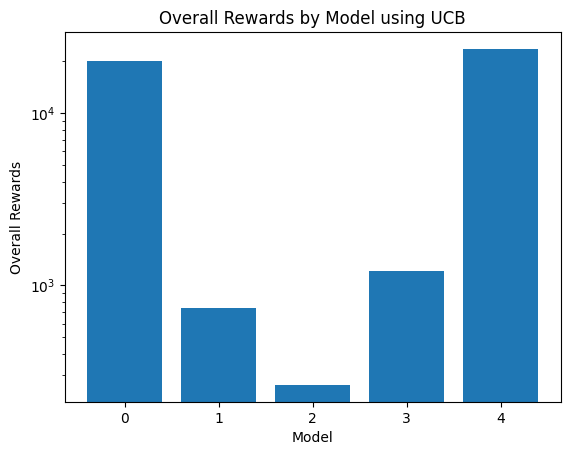

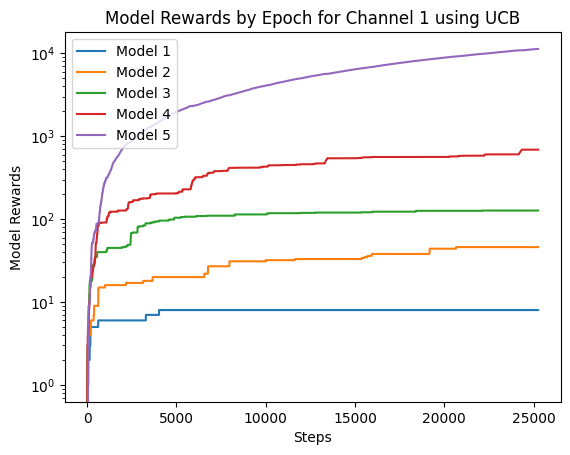

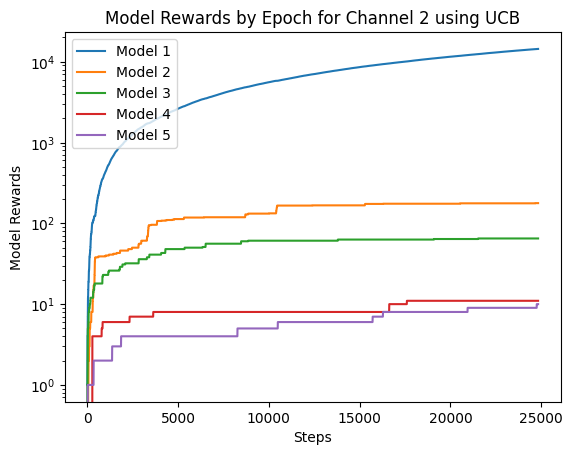

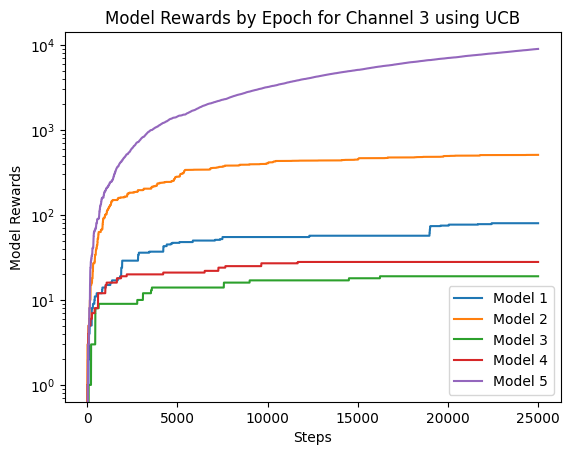

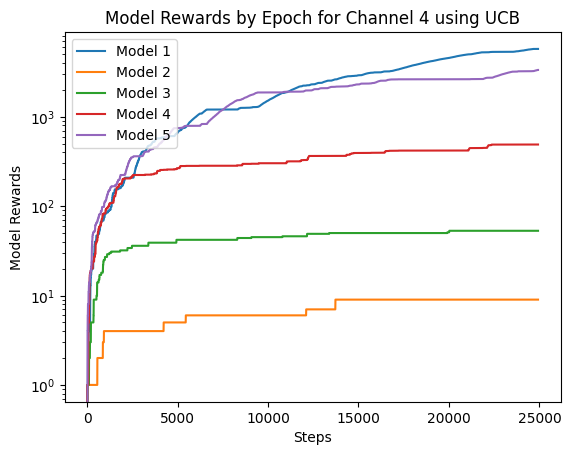

In [6]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ContextualBandit:
    """A contextual bandit algorithm designed for an e-commerce platform with four contexts or channels.
    
    Attributes:
        n_channels (int): The number of channels or contexts.
        n_models (int): The number of models to run in each context.
        rewards (numpy.ndarray): A 2D array of rewards for each channel and model.
    """
    def __init__(self):
        """Initializes the ContextualBandit class"""
        self.n_channels = 4
        self.n_models = 5
        self.rewards = np.array([[0.1, 0.2, 0.3, 0.4, 0.5],
                                 [0.6, 0.4, 0.3, 0.2, 0.1],
                                 [0.2, 0.3, 0.1, 0.1, 0.4],
                                 [0.4, 0.1, 0.2, 0.3, 0.4]])
    
    def get_reward(self, channel, model):
        """Get the reward for a given channel and model.
        
        Args:
            channel (int): The channel or context.
            model (int): The model to select.
            
        Returns:
            int: The reward for the selected model.
        """
        reward = 0
        # For demonstration purposes, the reward is 1 if a random number is less than the reward probability. This should be replaced with the actual reward in deployment.
        if np.random.rand() < self.rewards[channel][model]:
            reward = 1
        return reward


class UCB_Agent:
    """An implementation of the Upper Confidence Bound (UCB) algorithm.
    
    Attributes:
        n_models (int): The number of models to select from.
        n_channels (int): The number of channels or contexts.
        model_counts (numpy.ndarray): An array of counts for each model.
        model_counts_per_channel (numpy.ndarray): A 2D array of counts for each model and channel.
        model_rewards (numpy.ndarray): An array of rewards for each model.
        total_counts (int): The total number of counts across all models. This represents the number of recommendations viewed
        total_counts_per_channel (numpy.ndarray): An array of counts for each channel.
        model_rewards_per_channel (numpy.ndarray): A 2D array of rewards for each model and channel.
        model_rewards_per_channel_per_epoch (numpy.ndarray): A 3D array of rewards per channel per epoch.
        channel_played_per_epoch (numpy.ndarray): A 2D array of channels played per epoch.
    """
    def __init__(self, n_models, n_channels, epochs):
        """Initializes the UCB_Agent class
        
        Args:
            n_models (int): The number of models to select from.
            n_channels (int): The number of channels or contexts.
            epochs (int): The number of epochs or iterations of the simulation.
        """
        self.n_models = n_models
        self.n_channels = n_channels
        self.model_counts = np.zeros(n_models)
        self.model_counts_per_channel = np.zeros((n_channels, n_models))
        self.model_rewards = np.zeros(n_models)
        self.total_counts = 0
        self.total_counts_per_channel= np.zeros(n_channels)
        self.model_rewards_per_channel = np.zeros((n_channels, n_models))
        # Add a variable to track rewards per model per channel per epoch
        self.model_rewards_per_channel_per_epoch = np.zeros((epochs, n_channels, n_models))
        self.channel_played_per_epoch = np.zeros((epochs, n_channels))
        
    def select_model(self, channel, bandit, epoch):
        """Select the best model based on the UCB algorithm.
        
        Args:
            channel (int): The channel or context.
            bandit (ContextualBandit): The contextual bandit to train.
            epochs (int): The number of epochs or iterations of the simulation.
        Returns:
            int: The index of the selected model.
        """
        ucb_values = np.zeros(self.n_models)
        for i in range(self.n_models):
            if self.model_counts_per_channel[channel,i] == 0:
                # Explore a model if it has not been selected before by setting the UCB value to infinity.
                ucb_values[i] = np.inf
            else:
                average_reward = self.model_rewards_per_channel[channel,i] / self.model_counts_per_channel[channel,i]
                # Explore more for models with low selection counts.
                exploration = np.sqrt(2 * np.log(self.total_counts_per_channel[channel]) / self.model_counts_per_channel[channel,i])
                ucb_values[i] = average_reward + exploration
        model = np.argmax(ucb_values)
        self.model_counts[model] += 1
        self.model_counts_per_channel[channel, model] += 1
        self.total_counts += 1
        self.total_counts_per_channel[channel] += 1
        reward = bandit.get_reward(channel, model)
        self.model_rewards[model] += reward
        self.model_rewards_per_channel[channel, model] += reward
        # Update the rewards per model per channel per epoch by adding the reward for the selected model to previous step's reward.
        self.model_rewards_per_channel_per_epoch[epoch, channel, model] = self.model_rewards_per_channel[channel, model]
        # Update other non-selected models rewards per channel per epoch by setting the previous model_rewards_per_channel value of those model to be the current value.
        self.model_rewards_per_channel_per_epoch[epoch, channel, np.arange(self.n_models) != model] = self.model_rewards_per_channel[channel, np.arange(self.n_models) != model]
        self.channel_played_per_epoch[epoch, channel] = 1
        return model
    
def train_bandit(bandit, ucb, epochs):
    """Train the contextual bandit using the UCB algorithm.
    
    Args:
        bandit (ContextualBandit): The contextual bandit to train.
        ucb (UCB_Agent): The UCB algorithm to use for model selection.
        epochs (int): The number of training epochs.
        
    Returns:
        numpy.ndarray: An array of rewards for each epoch.
    """
    rewards = np.zeros(epochs)
    for i in range(epochs):
        channel = np.random.randint(bandit.n_channels)
        model = ucb.select_model(channel, bandit, i)
        reward = bandit.get_reward(channel, model)
        rewards[i] = reward
    return rewards

if __name__ == '__main__':
    epochs = 100000
    bandit = ContextualBandit()
    ucb = UCB_Agent(bandit.n_models, bandit.n_channels, epochs)
    rewards = train_bandit(bandit, ucb, epochs)
    print('Average reward:', np.mean(rewards))

    # create a dataframe with model rewards and group by channel
    df = pd.DataFrame(ucb.model_rewards_per_channel, columns=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
    df['Channel'] = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']
    df = df.set_index('Channel')

    df.plot(kind='bar', rot=0)
    plt.xlabel('Channel')
    plt.ylabel('Model Rewards')
    plt.title('Model Rewards by Channel using UCB')
    plt.yscale('log')

    # create a bar chart of the overall rewards for each model
    plt.figure()
    plt.bar(range(ucb.n_models), ucb.model_rewards)
    plt.xlabel('Model')
    plt.ylabel('Overall Rewards')
    plt.title('Overall Rewards by Model using UCB')
    plt.yscale('log')
    plt.show()
    

    # create line charts of the model reward per channel per played epoch
    for channel in range(ucb.n_channels):
        played_epochs = np.where(ucb.channel_played_per_epoch[:, channel] == 1)[0]
        plt.figure()
        for model in range(ucb.n_models):
            plt.plot(np.arange(len(played_epochs)), ucb.model_rewards_per_channel_per_epoch[played_epochs, channel, model], label=f'Model {model+1}')
        plt.xlabel('Steps')
        plt.ylabel('Model Rewards')
        plt.title(f'Model Rewards by Epoch for Channel {channel+1} using UCB')
        plt.yscale('log')
        plt.legend()
        plt.show()
